In [1]:
!pip install albumentations
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

In [2]:
!pip install segmentation-models-pytorch
!pip install torchsummary


In [3]:
!pip install huggingface-hub==0.16.4


  Using cached huggingface_hub-0.16.4-py3-none-any.whl.metadata (12 kB)
Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.26.0
    Uninstalling huggingface-hub-0.26.0:
      Successfully uninstalled huggingface-hub-0.26.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.21.0 requires huggingface-hub>=0.21.2, but you have huggingface-hub 0.16.4 which is incompatible.
segmentation-models-pytorch 0.3.4 requires huggingface-hub>=0.24.6, but you have huggingface-hub 0.16.4 which is incompatible.
transformers 4.44.2 requires huggingface-hub<1.0,>=0.23.2, but you have huggingface-hub 0.16.4 which is incompatible.


In [4]:
import segmentation_models_pytorch as smp
from torchsummary import summary


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

#!pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

#print(os.getenv('PATH'))
print(torch.cuda.is_available())

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True


c:\Users\Yang_PC\anaconda3\envs\py310cuda118\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


device(type='cuda')

In [6]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision not available.")

torch version: 2.1.1+cu118
torchvision version: 0.16.1+cu118


In [7]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should return the current GPU device
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU


True
0
NVIDIA GeForce RTX 3060


In [8]:
import os
import pandas as pd

# Define paths to the train, valid, and test image and mask folders
# Example usage
main_folder = r'D:\ML_Seagrass\SourceData\Oregon\Oregon'

train_image_folder = os.path.join(main_folder, 'train', 'image')
train_mask_folder = os.path.join(main_folder, 'train', 'index')
val_image_folder = os.path.join(main_folder, 'valid', 'image')
val_mask_folder = os.path.join(main_folder, 'valid', 'index')
test_image_folder = os.path.join(main_folder, 'test', 'image')
test_mask_folder = os.path.join(main_folder, 'test', 'index')
    
# Function to create dataframes from the given folder structure
def create_dataframes_from_main_folder(main_folder):
    

    # Helper function to create a dataframe from image and mask folders
    def create_dataframe_from_folders(image_folder, mask_folder):
        image_names = [img.split('.')[0] for img in os.listdir(image_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]
        mask_names = [mask.split('.')[0] for mask in os.listdir(mask_folder) if mask.endswith(('.jpg', '.png', '.jpeg'))]

        # Ensure that the image and mask file names match
        assert set(image_names) == set(mask_names), "Image and mask file names do not match!"

        return pd.DataFrame({'id': image_names})

    # Create dataframes for train, valid, and test sets
    df_train = create_dataframe_from_folders(train_image_folder, train_mask_folder)
    df_val = create_dataframe_from_folders(val_image_folder, val_mask_folder)
    df_test = create_dataframe_from_folders(test_image_folder, test_mask_folder)

    # Return dataframes
    return df_train, df_val, df_test

  # Replace with the path to your main folder
df_train, df_val, df_test = create_dataframes_from_main_folder(main_folder)

# Assign X_train, X_val, and X_test
X_train = df_train['id'].values
X_val = df_val['id'].values
X_test = df_test['id'].values


Image Path: D:\ML_Seagrass\SourceData\Oregon\Oregon\valid\image\BA_OR_19_row10_col3.png
Mask Path: D:\ML_Seagrass\SourceData\Oregon\Oregon\valid\index\BA_OR_19_row10_col3.png


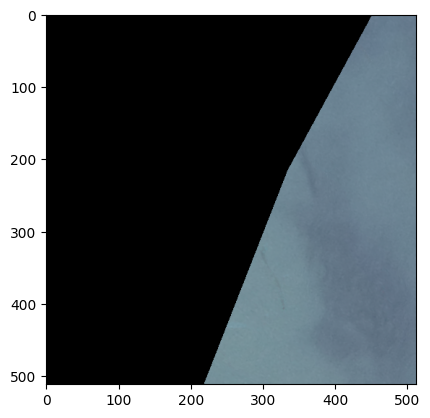

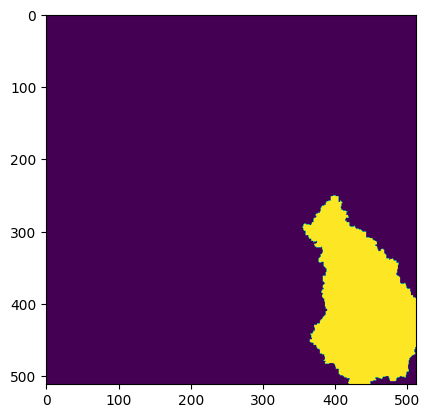

(512, 512, 3)
(512, 512)


In [9]:
for idx in X_val:
    img_path = os.path.join(val_image_folder, idx + '.png')
    mask_path = os.path.join(val_mask_folder, idx + '.png')

    
    # Print out the file paths for debugging
    print("Image Path:", img_path)
    print("Mask Path:", mask_path)
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    plt.imshow(img)
    plt.show()
    plt.imshow(mask)
    plt.show()
    print(np.asarray(img).shape)
    print(np.asarray(mask).shape)
    break

In [10]:
from pathlib import Path

class Drone_data(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_path = self.img_path / f'{self.X[idx]}.png'
        mask_path = self.mask_path / f'{self.X[idx]}.png'
        
        # Read and convert the image to RGB
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Open and convert the mask to grayscale
        mask = Image.open(mask_path)
        mask = mask.convert("L")
        mask = np.array(mask)

        # Map mask values: 255 -> 1
        mask = np.where(mask == 255, 1, 0).astype(np.uint8)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']

        # Convert image to tensor and normalize
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        
        # Convert mask to a tensor
        mask = torch.from_numpy(mask).long()

        if self.patch:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):
        # Implementation of tile extraction if needed
        pass

In [11]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = Drone_data(train_image_folder, train_mask_folder, X_train, mean, std, t_train, patch=False)
val_set = Drone_data(val_image_folder, val_mask_folder, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [12]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=2, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [13]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [14]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [15]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [16]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            #output = torch.argmax(output, dim=1)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    
    total_time_minutes = (time.time() - fit_time) / 60

    # Print the total time
    print('Total time: {:.2f} m'.format(total_time_minutes))

    #print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [17]:
torch.cuda.empty_cache()

In [18]:
import subprocess

def check_gpu_memory():
    result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(result.stdout.decode('utf-8'))

check_gpu_memory()

Sun Oct 20 11:54:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 37%   36C    P8             11W /  170W |     575MiB /  12288MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [19]:
max_lr = 1e-4
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

torch.save(model, 'Unet-mobilenet2-batchsize4-OR_lr-4.pt')

  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.846 
Epoch:1/20.. Train Loss: 0.713.. Val Loss: 0.846.. Train mIoU:0.429.. Val mIoU: 0.459.. Train Acc:0.605.. Val Acc:0.647.. Time: 8.38m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Decreasing.. 0.846 >> 0.646 
Epoch:2/20.. Train Loss: 0.603.. Val Loss: 0.646.. Train mIoU:0.506.. Val mIoU: 0.490.. Train Acc:0.677.. Val Acc:0.676.. Time: 6.86m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Decreasing.. 0.646 >> 0.627 
Epoch:3/20.. Train Loss: 0.560.. Val Loss: 0.627.. Train mIoU:0.552.. Val mIoU: 0.524.. Train Acc:0.713.. Val Acc:0.707.. Time: 6.88m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Decreasing.. 0.627 >> 0.503 
saving model...
Epoch:4/20.. Train Loss: 0.536.. Val Loss: 0.503.. Train mIoU:0.576.. Val mIoU: 0.594.. Train Acc:0.733.. Val Acc:0.762.. Time: 6.90m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Decreasing.. 0.503 >> 0.477 
Epoch:5/20.. Train Loss: 0.523.. Val Loss: 0.477.. Train mIoU:0.586.. Val mIoU: 0.608.. Train Acc:0.741.. Val Acc:0.776.. Time: 7.05m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Decreasing.. 0.477 >> 0.474 
Epoch:6/20.. Train Loss: 0.515.. Val Loss: 0.474.. Train mIoU:0.594.. Val mIoU: 0.614.. Train Acc:0.748.. Val Acc:0.778.. Time: 7.00m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:7/20.. Train Loss: 0.499.. Val Loss: 0.511.. Train mIoU:0.611.. Val mIoU: 0.574.. Train Acc:0.761.. Val Acc:0.753.. Time: 6.98m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Decreasing.. 0.511 >> 0.474 
Epoch:8/20.. Train Loss: 0.495.. Val Loss: 0.474.. Train mIoU:0.612.. Val mIoU: 0.628.. Train Acc:0.762.. Val Acc:0.792.. Time: 6.98m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:9/20.. Train Loss: 0.480.. Val Loss: 0.499.. Train mIoU:0.623.. Val mIoU: 0.580.. Train Acc:0.773.. Val Acc:0.745.. Time: 6.97m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Decreasing.. 0.499 >> 0.478 
Epoch:10/20.. Train Loss: 0.480.. Val Loss: 0.478.. Train mIoU:0.618.. Val mIoU: 0.629.. Train Acc:0.769.. Val Acc:0.784.. Time: 6.99m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:11/20.. Train Loss: 0.468.. Val Loss: 0.505.. Train mIoU:0.630.. Val mIoU: 0.630.. Train Acc:0.779.. Val Acc:0.789.. Time: 7.09m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Decreasing.. 0.505 >> 0.457 
saving model...
Epoch:12/20.. Train Loss: 0.463.. Val Loss: 0.457.. Train mIoU:0.635.. Val mIoU: 0.641.. Train Acc:0.784.. Val Acc:0.801.. Time: 7.04m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:13/20.. Train Loss: 0.453.. Val Loss: 0.486.. Train mIoU:0.640.. Val mIoU: 0.635.. Train Acc:0.788.. Val Acc:0.794.. Time: 7.02m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Decreasing.. 0.486 >> 0.437 
Epoch:14/20.. Train Loss: 0.448.. Val Loss: 0.437.. Train mIoU:0.641.. Val mIoU: 0.639.. Train Acc:0.789.. Val Acc:0.803.. Time: 7.02m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:15/20.. Train Loss: 0.443.. Val Loss: 0.441.. Train mIoU:0.650.. Val mIoU: 0.649.. Train Acc:0.794.. Val Acc:0.806.. Time: 7.03m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:16/20.. Train Loss: 0.439.. Val Loss: 0.441.. Train mIoU:0.649.. Val mIoU: 0.645.. Train Acc:0.797.. Val Acc:0.806.. Time: 7.06m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Decreasing.. 0.441 >> 0.438 
Epoch:17/20.. Train Loss: 0.435.. Val Loss: 0.438.. Train mIoU:0.654.. Val mIoU: 0.648.. Train Acc:0.799.. Val Acc:0.807.. Time: 7.00m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Decreasing.. 0.438 >> 0.430 
Epoch:18/20.. Train Loss: 0.431.. Val Loss: 0.430.. Train mIoU:0.655.. Val mIoU: 0.656.. Train Acc:0.801.. Val Acc:0.807.. Time: 6.99m


  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 134.29 m


In [20]:
model_path = r'C:\Users\Yang_PC\Documents\Github\ArcgisPro-Customized-Toolbox\Notebook\Unet-mobilenet2-batchsize4-OR_lr-4.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_path)
model.to(device)




Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [21]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

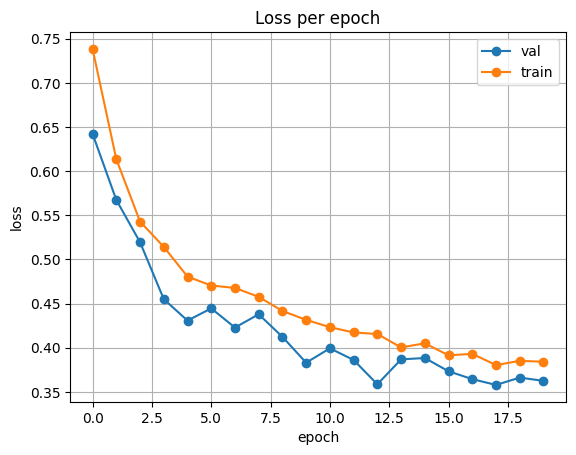

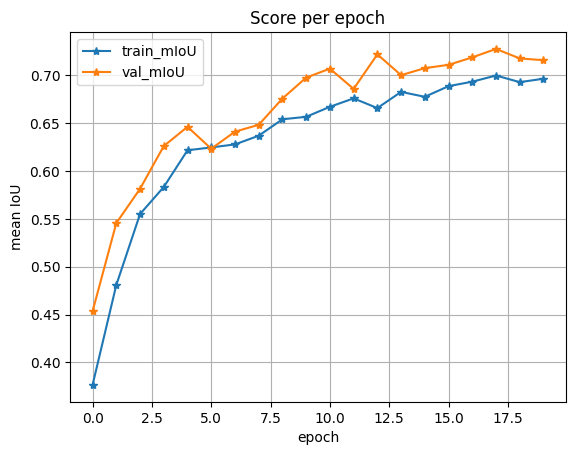

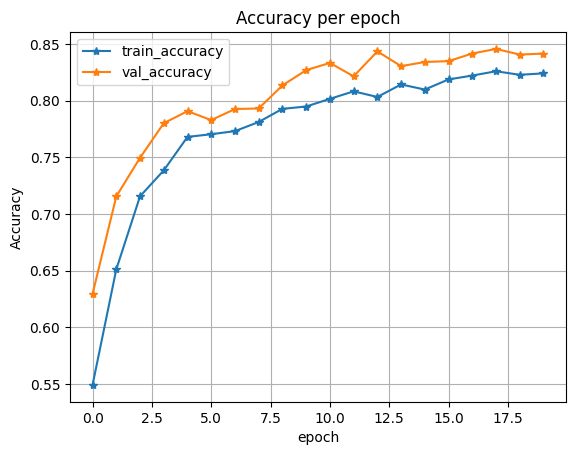

In [28]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [22]:
class DroneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_file_name = f'{self.X[idx]}.png'
        img_path = self.img_path / img_file_name
        mask_path = self.mask_path / img_file_name
        
        # Read and convert the image to RGB using OpenCV
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Read the mask in grayscale directly using OpenCV
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            # Convert image and mask to NumPy arrays for transformation
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        # Convert the image to PIL Image (consistent with DroneTestDataset1)
        img = Image.fromarray(img)

        # Convert mask to a PyTorch tensor
        mask = torch.from_numpy(mask).long()

        # Return the image, mask, and file name
        return img, mask, img_file_name

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(test_image_folder, test_mask_folder, X_test, transform=t_test)

In [23]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np


# Updated function to perform inference and save the predicted mask with resizing
def predict_image_mask_miou(model, image, mask, save_file, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()  # Set the model to evaluation mode
    
    # Store original image dimensions before transforming
    original_height, original_width = 512, 512  # PIL Image size: (width, height)
    
    # Apply transformation to the image (e.g., normalization)
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image_tensor = t(image)  # Keep 'image' unchanged for later use
    
    # Move image and mask to the appropriate device
    image_tensor = image_tensor.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():  # Disable gradient calculation for inference
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension for the model
        mask = mask.unsqueeze(0)    # Add batch dimension

        output = model(image_tensor)  # Run model inference
        score = mIoU(output, mask)  # Compute mIoU score
        
        # Get the predicted mask by taking the argmax of the model's output
        pred_mask = torch.argmax(output, dim=1)
        pred_mask = pred_mask.cpu().squeeze(0)  # Move to CPU and remove batch dimension

    # Resize the predicted mask to match the original image size
    pred_mask_resized = cv2.resize(pred_mask.numpy(), (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    
    # Save the resized predicted mask as a grayscale image
    plt.imsave(save_file, pred_mask_resized, cmap='gray')  # Save mask as a grayscale image
    
    return pred_mask_resized, score



def save_predicted_mask_overlay(pred_mask, img_file_name, image_folder, save_file, alpha=0.5):
    """
    Overlays the predicted mask on the original image read from a specified folder, and saves the result.
    
    Parameters:
    - pred_mask: The predicted mask (PyTorch tensor or NumPy array with values 0 and 1).
    - img_file_name: The name of the image file (e.g., 'image_001.png').
    - image_folder: The path to the folder where the original image is located.
    - save_file: The path to save the overlaid image.
    - alpha: The transparency factor for the overlay (default is 0.3 for higher transparency).
    """
    # Build the full image path
    img_path = os.path.join(image_folder, img_file_name)

    # Read the original image from the specified folder
    original_image = Image.open(img_path).convert('RGB')  # Use PIL to read the image
    original_image = np.array(original_image)  # Convert to NumPy array

    # Convert the predicted mask to a NumPy array if it's a PyTorch tensor
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu().numpy()

    # Ensure the predicted mask has 2D shape (height, width)
    if pred_mask.ndim != 2:
        raise ValueError(f"Expected 2D mask, but got shape {pred_mask.shape}")

    # Resize the predicted mask to match the original image size (assuming original image size is 512x512)
    original_height, original_width = original_image.shape[:2]
    pred_mask_resized = cv2.resize(pred_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    # Ensure the image is in the correct format (height, width, 3)
    if original_image.ndim != 3 or original_image.shape[2] != 3:
        raise ValueError(f"Expected 3D RGB image, but got shape {original_image.shape}")

    # Create a copy of the original image to modify
    overlay = original_image.copy()

    # Broadcast the mask across the 3 RGB channels (set the mask area to light blue)
    light_blue_color = [78,156,217]  # Light blue RGB
    light_blue_mask = np.zeros_like(overlay)
    light_blue_mask[pred_mask_resized == 1] = light_blue_color  # Light blue for class 1 (object)

    # Blend the original image and the light blue mask, keeping the original image intensity intact
    blended_image = cv2.addWeighted(light_blue_mask, alpha, original_image, 1, 0)

    # Save the blended image
    plt.imsave(save_file, blended_image)
    print(f"Saved overlay image: {save_file}")


In [24]:
import os
from tqdm import tqdm

# Define the save path for the predicted masks and the folder for original images
original_image_folder = r'D:\ML_Seagrass\SourceData\Oregon\Oregon\test\image'  # Folder with original images
save_path = r'D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay'
Pred_mask_path = r'D:\ML_Seagrass\SourceData\Oregon\Oregon\test\predicted'

# Ensure the directories exist
os.makedirs(save_path, exist_ok=True)
os.makedirs(Pred_mask_path, exist_ok=True)

# Loop through all images in the test set
for idx in tqdm(range(len(test_set))):
    image, mask, img_file_name = test_set[idx]  # Get mask and filename from test_set
    
    # Define the save path for the current predicted mask
    save_overlay_file = os.path.join(save_path, f'{img_file_name}')  # Save with filename
    save_predicted_file = os.path.join(Pred_mask_path, f'{img_file_name}')
     
    # Run inference to get the predicted mask
    pred_mask, score = predict_image_mask_miou(model, image, mask, save_predicted_file)
    
    # Save the overlay of the predicted mask on the original image read from `original_image_folder`
    save_predicted_mask_overlay(pred_mask, img_file_name, original_image_folder, save_overlay_file)
    
    # Optionally, log the progress or save additional data
    print(f"Saved predicted mask for {img_file_name} with mIoU score: {score:.3f}")


  0%|          | 1/296 [00:00<03:00,  1.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_19_row10_col4.png
Saved predicted mask for BA_OR_19_row10_col4.png with mIoU score: 0.794


  1%|          | 2/296 [00:00<02:06,  2.33it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_19_row12_col11.png
Saved predicted mask for BA_OR_19_row12_col11.png with mIoU score: 0.008


  1%|          | 3/296 [00:01<01:50,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_19_row13_col10.png
Saved predicted mask for BA_OR_19_row13_col10.png with mIoU score: 0.005


  1%|▏         | 4/296 [00:01<01:42,  2.86it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_19_row14_col11.png
Saved predicted mask for BA_OR_19_row14_col11.png with mIoU score: 0.049


  2%|▏         | 6/296 [00:02<01:27,  3.31it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_19_row14_col14.png
Saved predicted mask for BA_OR_19_row14_col14.png with mIoU score: 0.178
Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_19_row17_col10.png
Saved predicted mask for BA_OR_19_row17_col10.png with mIoU score: 0.758


  2%|▏         | 7/296 [00:02<01:31,  3.15it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_19_row4_col11.png
Saved predicted mask for BA_OR_19_row4_col11.png with mIoU score: 0.056


  3%|▎         | 8/296 [00:02<01:33,  3.10it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_19_row7_col9.png
Saved predicted mask for BA_OR_19_row7_col9.png with mIoU score: 0.213


  3%|▎         | 9/296 [00:03<01:33,  3.08it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_19_row9_col16.png
Saved predicted mask for BA_OR_19_row9_col16.png with mIoU score: 0.703


  3%|▎         | 10/296 [00:03<01:37,  2.93it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row10_col24.png
Saved predicted mask for BA_OR_21_row10_col24.png with mIoU score: 0.598


  4%|▎         | 11/296 [00:03<01:39,  2.87it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row10_col8.png
Saved predicted mask for BA_OR_21_row10_col8.png with mIoU score: 0.431


  4%|▍         | 12/296 [00:04<01:42,  2.78it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row11_col8.png
Saved predicted mask for BA_OR_21_row11_col8.png with mIoU score: 0.678


  4%|▍         | 13/296 [00:04<01:45,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row12_col21.png
Saved predicted mask for BA_OR_21_row12_col21.png with mIoU score: 0.948


  5%|▍         | 14/296 [00:04<01:42,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row12_col23.png
Saved predicted mask for BA_OR_21_row12_col23.png with mIoU score: 0.889


  5%|▌         | 15/296 [00:05<01:42,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row12_col24.png
Saved predicted mask for BA_OR_21_row12_col24.png with mIoU score: 0.707


  5%|▌         | 16/296 [00:05<01:42,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row15_col12.png
Saved predicted mask for BA_OR_21_row15_col12.png with mIoU score: 0.034


  6%|▌         | 17/296 [00:06<01:43,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row15_col23.png
Saved predicted mask for BA_OR_21_row15_col23.png with mIoU score: 0.552


  6%|▌         | 18/296 [00:06<01:42,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row15_col28.png
Saved predicted mask for BA_OR_21_row15_col28.png with mIoU score: 0.766


  6%|▋         | 19/296 [00:06<01:43,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row16_col26.png
Saved predicted mask for BA_OR_21_row16_col26.png with mIoU score: 0.387


  7%|▋         | 20/296 [00:07<01:49,  2.53it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row17_col25.png
Saved predicted mask for BA_OR_21_row17_col25.png with mIoU score: 0.567


  7%|▋         | 21/296 [00:07<01:50,  2.49it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row18_col14.png
Saved predicted mask for BA_OR_21_row18_col14.png with mIoU score: 0.757


  7%|▋         | 22/296 [00:08<01:47,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row18_col26.png
Saved predicted mask for BA_OR_21_row18_col26.png with mIoU score: 0.900


  8%|▊         | 23/296 [00:08<01:44,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row18_col4.png
Saved predicted mask for BA_OR_21_row18_col4.png with mIoU score: 0.369


  8%|▊         | 24/296 [00:08<01:43,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row18_col5.png
Saved predicted mask for BA_OR_21_row18_col5.png with mIoU score: 0.552


  8%|▊         | 25/296 [00:09<01:46,  2.54it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row19_col14.png
Saved predicted mask for BA_OR_21_row19_col14.png with mIoU score: 0.940


  9%|▉         | 26/296 [00:09<01:50,  2.45it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row19_col6.png
Saved predicted mask for BA_OR_21_row19_col6.png with mIoU score: 0.114


  9%|▉         | 27/296 [00:10<01:46,  2.52it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row20_col13.png
Saved predicted mask for BA_OR_21_row20_col13.png with mIoU score: 0.903


  9%|▉         | 28/296 [00:10<01:45,  2.55it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row20_col25.png
Saved predicted mask for BA_OR_21_row20_col25.png with mIoU score: 0.679


 10%|▉         | 29/296 [00:10<01:43,  2.58it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row21_col10.png
Saved predicted mask for BA_OR_21_row21_col10.png with mIoU score: 0.965


 10%|█         | 30/296 [00:11<01:43,  2.58it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row21_col18.png
Saved predicted mask for BA_OR_21_row21_col18.png with mIoU score: 0.813


 10%|█         | 31/296 [00:11<01:41,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row21_col19.png
Saved predicted mask for BA_OR_21_row21_col19.png with mIoU score: 0.848


 11%|█         | 32/296 [00:11<01:41,  2.60it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row21_col25.png
Saved predicted mask for BA_OR_21_row21_col25.png with mIoU score: 0.870


 11%|█         | 33/296 [00:12<01:41,  2.60it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row21_col5.png
Saved predicted mask for BA_OR_21_row21_col5.png with mIoU score: 0.448


 11%|█▏        | 34/296 [00:12<01:39,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row22_col24.png
Saved predicted mask for BA_OR_21_row22_col24.png with mIoU score: 0.709


 12%|█▏        | 35/296 [00:13<01:38,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row23_col18.png
Saved predicted mask for BA_OR_21_row23_col18.png with mIoU score: 0.590


 12%|█▏        | 36/296 [00:13<01:45,  2.46it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row23_col22.png
Saved predicted mask for BA_OR_21_row23_col22.png with mIoU score: 0.441


 12%|█▎        | 37/296 [00:13<01:43,  2.49it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row25_col12.png
Saved predicted mask for BA_OR_21_row25_col12.png with mIoU score: 0.844


 13%|█▎        | 38/296 [00:14<02:05,  2.05it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row25_col18.png
Saved predicted mask for BA_OR_21_row25_col18.png with mIoU score: 0.690


 13%|█▎        | 39/296 [00:14<01:54,  2.24it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row27_col15.png
Saved predicted mask for BA_OR_21_row27_col15.png with mIoU score: 0.803


 14%|█▎        | 40/296 [00:15<01:38,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row28_col16.png
Saved predicted mask for BA_OR_21_row28_col16.png with mIoU score: 0.972


 14%|█▍        | 41/296 [00:15<01:39,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row28_col19.png
Saved predicted mask for BA_OR_21_row28_col19.png with mIoU score: 0.595


 14%|█▍        | 42/296 [00:16<01:39,  2.55it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row28_col20.png
Saved predicted mask for BA_OR_21_row28_col20.png with mIoU score: 0.491


 15%|█▍        | 43/296 [00:16<01:34,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row29_col19.png
Saved predicted mask for BA_OR_21_row29_col19.png with mIoU score: 0.843


 15%|█▍        | 44/296 [00:16<01:36,  2.60it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row4_col18.png
Saved predicted mask for BA_OR_21_row4_col18.png with mIoU score: 0.520


 15%|█▌        | 45/296 [00:17<01:34,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row4_col19.png
Saved predicted mask for BA_OR_21_row4_col19.png with mIoU score: 0.521


 16%|█▌        | 46/296 [00:17<01:36,  2.60it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row5_col13.png
Saved predicted mask for BA_OR_21_row5_col13.png with mIoU score: 0.429


 16%|█▌        | 47/296 [00:17<01:35,  2.60it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row5_col15.png
Saved predicted mask for BA_OR_21_row5_col15.png with mIoU score: 0.160


 16%|█▌        | 48/296 [00:18<01:36,  2.58it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row6_col14.png
Saved predicted mask for BA_OR_21_row6_col14.png with mIoU score: 0.255


 17%|█▋        | 49/296 [00:18<01:35,  2.57it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row6_col21.png
Saved predicted mask for BA_OR_21_row6_col21.png with mIoU score: 0.002


 17%|█▋        | 50/296 [00:19<01:30,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row6_col23.png
Saved predicted mask for BA_OR_21_row6_col23.png with mIoU score: 0.995


 17%|█▋        | 51/296 [00:19<01:35,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row8_col25.png
Saved predicted mask for BA_OR_21_row8_col25.png with mIoU score: 0.051


 18%|█▊        | 52/296 [00:19<01:30,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_21_row9_col28.png
Saved predicted mask for BA_OR_21_row9_col28.png with mIoU score: 0.960


 18%|█▊        | 53/296 [00:20<01:20,  3.04it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\BA_OR_22_row1_col1.png
Saved predicted mask for BA_OR_22_row1_col1.png with mIoU score: 0.987


 18%|█▊        | 54/296 [00:20<01:26,  2.81it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row10_col1.png
Saved predicted mask for FO_OR_19_row10_col1.png with mIoU score: 0.443


 19%|█▊        | 55/296 [00:20<01:30,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row10_col11.png
Saved predicted mask for FO_OR_19_row10_col11.png with mIoU score: 0.533


 19%|█▉        | 56/296 [00:21<01:29,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row11_col13.png
Saved predicted mask for FO_OR_19_row11_col13.png with mIoU score: 0.580


 19%|█▉        | 57/296 [00:21<01:28,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row13_col12.png
Saved predicted mask for FO_OR_19_row13_col12.png with mIoU score: 0.416


 20%|█▉        | 58/296 [00:21<01:28,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row14_col2.png
Saved predicted mask for FO_OR_19_row14_col2.png with mIoU score: 0.782


 20%|█▉        | 59/296 [00:22<01:46,  2.23it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row14_col6.png
Saved predicted mask for FO_OR_19_row14_col6.png with mIoU score: 0.460


 20%|██        | 60/296 [00:22<01:42,  2.30it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row15_col5.png
Saved predicted mask for FO_OR_19_row15_col5.png with mIoU score: 0.928


 21%|██        | 61/296 [00:23<01:36,  2.42it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row16_col8.png
Saved predicted mask for FO_OR_19_row16_col8.png with mIoU score: 0.345


 21%|██        | 62/296 [00:23<01:35,  2.44it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row18_col6.png
Saved predicted mask for FO_OR_19_row18_col6.png with mIoU score: 0.422


 21%|██▏       | 63/296 [00:24<01:32,  2.52it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row19_col10.png
Saved predicted mask for FO_OR_19_row19_col10.png with mIoU score: 0.667


 22%|██▏       | 64/296 [00:24<01:30,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row19_col13.png
Saved predicted mask for FO_OR_19_row19_col13.png with mIoU score: 0.761


 22%|██▏       | 65/296 [00:24<01:23,  2.76it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row1_col10.png
Saved predicted mask for FO_OR_19_row1_col10.png with mIoU score: 0.985


 22%|██▏       | 66/296 [00:25<01:27,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row22_col2.png
Saved predicted mask for FO_OR_19_row22_col2.png with mIoU score: 0.849


 23%|██▎       | 67/296 [00:25<01:15,  3.04it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row2_col14.png
Saved predicted mask for FO_OR_19_row2_col14.png with mIoU score: 0.985


 23%|██▎       | 68/296 [00:25<01:16,  2.99it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row4_col13.png
Saved predicted mask for FO_OR_19_row4_col13.png with mIoU score: 0.093


 23%|██▎       | 69/296 [00:26<01:17,  2.92it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row6_col12.png
Saved predicted mask for FO_OR_19_row6_col12.png with mIoU score: 0.407


 24%|██▎       | 70/296 [00:26<01:14,  3.05it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row6_col14.png
Saved predicted mask for FO_OR_19_row6_col14.png with mIoU score: 0.886


 24%|██▍       | 71/296 [00:26<01:15,  2.98it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_19_row8_col6.png
Saved predicted mask for FO_OR_19_row8_col6.png with mIoU score: 0.150


 24%|██▍       | 72/296 [00:27<01:17,  2.88it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row10_col19.png
Saved predicted mask for FO_OR_21_row10_col19.png with mIoU score: 0.812


 25%|██▍       | 73/296 [00:27<01:18,  2.85it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row10_col22.png
Saved predicted mask for FO_OR_21_row10_col22.png with mIoU score: 0.658


 25%|██▌       | 74/296 [00:27<01:20,  2.76it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row11_col17.png
Saved predicted mask for FO_OR_21_row11_col17.png with mIoU score: 0.924


 25%|██▌       | 75/296 [00:28<01:20,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row11_col19.png
Saved predicted mask for FO_OR_21_row11_col19.png with mIoU score: 0.744


 26%|██▌       | 76/296 [00:28<01:19,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row11_col6.png
Saved predicted mask for FO_OR_21_row11_col6.png with mIoU score: 0.899


 26%|██▌       | 77/296 [00:29<01:23,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row14_col18.png
Saved predicted mask for FO_OR_21_row14_col18.png with mIoU score: 0.399


 26%|██▋       | 78/296 [00:29<01:41,  2.14it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row17_col16.png
Saved predicted mask for FO_OR_21_row17_col16.png with mIoU score: 0.347


 27%|██▋       | 79/296 [00:30<01:36,  2.26it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row19_col14.png
Saved predicted mask for FO_OR_21_row19_col14.png with mIoU score: 0.443


 27%|██▋       | 80/296 [00:30<01:30,  2.40it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row21_col16.png
Saved predicted mask for FO_OR_21_row21_col16.png with mIoU score: 0.894


 27%|██▋       | 81/296 [00:30<01:27,  2.46it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row21_col8.png
Saved predicted mask for FO_OR_21_row21_col8.png with mIoU score: 0.943


 28%|██▊       | 82/296 [00:31<01:25,  2.50it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row22_col13.png
Saved predicted mask for FO_OR_21_row22_col13.png with mIoU score: 0.810


 28%|██▊       | 83/296 [00:31<01:24,  2.52it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row23_col9.png
Saved predicted mask for FO_OR_21_row23_col9.png with mIoU score: 0.387


 28%|██▊       | 84/296 [00:32<01:25,  2.49it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row24_col19.png
Saved predicted mask for FO_OR_21_row24_col19.png with mIoU score: 0.888


 29%|██▊       | 85/296 [00:32<01:23,  2.54it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row26_col10.png
Saved predicted mask for FO_OR_21_row26_col10.png with mIoU score: 0.455


 29%|██▉       | 86/296 [00:32<01:20,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row26_col2.png
Saved predicted mask for FO_OR_21_row26_col2.png with mIoU score: 0.927


 29%|██▉       | 87/296 [00:33<01:22,  2.55it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row26_col22.png
Saved predicted mask for FO_OR_21_row26_col22.png with mIoU score: 0.867


 30%|██▉       | 88/296 [00:33<01:19,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row26_col25.png
Saved predicted mask for FO_OR_21_row26_col25.png with mIoU score: 0.652


 30%|███       | 89/296 [00:33<01:20,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row26_col6.png
Saved predicted mask for FO_OR_21_row26_col6.png with mIoU score: 0.804


 30%|███       | 90/296 [00:34<01:19,  2.60it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row26_col8.png
Saved predicted mask for FO_OR_21_row26_col8.png with mIoU score: 0.405


 31%|███       | 91/296 [00:34<01:18,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row27_col15.png
Saved predicted mask for FO_OR_21_row27_col15.png with mIoU score: 0.561


 31%|███       | 92/296 [00:35<01:20,  2.53it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row27_col8.png
Saved predicted mask for FO_OR_21_row27_col8.png with mIoU score: 0.353


 31%|███▏      | 93/296 [00:35<01:20,  2.53it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row28_col10.png
Saved predicted mask for FO_OR_21_row28_col10.png with mIoU score: 0.501


 32%|███▏      | 94/296 [00:35<01:20,  2.50it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row28_col12.png
Saved predicted mask for FO_OR_21_row28_col12.png with mIoU score: 0.945


 32%|███▏      | 95/296 [00:36<01:21,  2.47it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row28_col16.png
Saved predicted mask for FO_OR_21_row28_col16.png with mIoU score: 0.922


 32%|███▏      | 96/296 [00:36<01:20,  2.48it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row28_col9.png
Saved predicted mask for FO_OR_21_row28_col9.png with mIoU score: 0.497


 33%|███▎      | 97/296 [00:37<01:19,  2.49it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row29_col16.png
Saved predicted mask for FO_OR_21_row29_col16.png with mIoU score: 0.713


 33%|███▎      | 98/296 [00:37<01:19,  2.50it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row2_col14.png
Saved predicted mask for FO_OR_21_row2_col14.png with mIoU score: 0.650


 33%|███▎      | 99/296 [00:37<01:18,  2.51it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row2_col18.png
Saved predicted mask for FO_OR_21_row2_col18.png with mIoU score: 0.430


 34%|███▍      | 100/296 [00:38<01:17,  2.54it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row2_col19.png
Saved predicted mask for FO_OR_21_row2_col19.png with mIoU score: 0.343


 34%|███▍      | 101/296 [00:38<01:16,  2.53it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row2_col23.png
Saved predicted mask for FO_OR_21_row2_col23.png with mIoU score: 0.726


 34%|███▍      | 102/296 [00:39<01:19,  2.43it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row30_col19.png
Saved predicted mask for FO_OR_21_row30_col19.png with mIoU score: 0.414


 35%|███▍      | 103/296 [00:39<01:16,  2.52it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row30_col20.png
Saved predicted mask for FO_OR_21_row30_col20.png with mIoU score: 0.609


 35%|███▌      | 104/296 [00:39<01:15,  2.55it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row31_col17.png
Saved predicted mask for FO_OR_21_row31_col17.png with mIoU score: 0.597


 35%|███▌      | 105/296 [00:40<01:29,  2.14it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row31_col22.png
Saved predicted mask for FO_OR_21_row31_col22.png with mIoU score: 0.935


 36%|███▌      | 106/296 [00:40<01:21,  2.34it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row31_col5.png
Saved predicted mask for FO_OR_21_row31_col5.png with mIoU score: 0.735


 36%|███▌      | 107/296 [00:41<01:19,  2.39it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row32_col15.png
Saved predicted mask for FO_OR_21_row32_col15.png with mIoU score: 0.902


 36%|███▋      | 108/296 [00:41<01:16,  2.46it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row32_col3.png
Saved predicted mask for FO_OR_21_row32_col3.png with mIoU score: 0.806


 37%|███▋      | 109/296 [00:42<01:13,  2.55it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row33_col12.png
Saved predicted mask for FO_OR_21_row33_col12.png with mIoU score: 0.912


 37%|███▋      | 110/296 [00:42<01:11,  2.59it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row33_col13.png
Saved predicted mask for FO_OR_21_row33_col13.png with mIoU score: 0.929


 38%|███▊      | 111/296 [00:42<01:10,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row33_col2.png
Saved predicted mask for FO_OR_21_row33_col2.png with mIoU score: 0.620


 38%|███▊      | 112/296 [00:43<01:10,  2.62it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row33_col6.png
Saved predicted mask for FO_OR_21_row33_col6.png with mIoU score: 0.805


 38%|███▊      | 113/296 [00:43<01:08,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row34_col10.png
Saved predicted mask for FO_OR_21_row34_col10.png with mIoU score: 0.906


 39%|███▊      | 114/296 [00:43<01:06,  2.74it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row34_col17.png
Saved predicted mask for FO_OR_21_row34_col17.png with mIoU score: 0.634


 39%|███▉      | 115/296 [00:44<01:07,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row34_col22.png
Saved predicted mask for FO_OR_21_row34_col22.png with mIoU score: 0.630


 39%|███▉      | 116/296 [00:44<01:06,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row36_col8.png
Saved predicted mask for FO_OR_21_row36_col8.png with mIoU score: 0.841


 40%|███▉      | 117/296 [00:44<01:06,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row37_col1.png
Saved predicted mask for FO_OR_21_row37_col1.png with mIoU score: 0.835


 40%|███▉      | 118/296 [00:45<01:07,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row37_col14.png
Saved predicted mask for FO_OR_21_row37_col14.png with mIoU score: 0.429


 40%|████      | 119/296 [00:46<01:20,  2.20it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row37_col15.png
Saved predicted mask for FO_OR_21_row37_col15.png with mIoU score: 0.946


 41%|████      | 120/296 [00:46<01:16,  2.30it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row37_col16.png
Saved predicted mask for FO_OR_21_row37_col16.png with mIoU score: 0.801


 41%|████      | 121/296 [00:46<01:15,  2.31it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row37_col17.png
Saved predicted mask for FO_OR_21_row37_col17.png with mIoU score: 0.950


 41%|████      | 122/296 [00:47<01:12,  2.41it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row37_col23.png
Saved predicted mask for FO_OR_21_row37_col23.png with mIoU score: 0.537


 42%|████▏     | 123/296 [00:47<01:08,  2.53it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row37_col24.png
Saved predicted mask for FO_OR_21_row37_col24.png with mIoU score: 0.943


 42%|████▏     | 124/296 [00:47<01:08,  2.51it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row37_col3.png
Saved predicted mask for FO_OR_21_row37_col3.png with mIoU score: 0.667


 42%|████▏     | 125/296 [00:48<01:13,  2.34it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row38_col12.png
Saved predicted mask for FO_OR_21_row38_col12.png with mIoU score: 0.568


 43%|████▎     | 126/296 [00:48<01:12,  2.35it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row38_col9.png
Saved predicted mask for FO_OR_21_row38_col9.png with mIoU score: 0.881


 43%|████▎     | 127/296 [00:49<01:07,  2.52it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row39_col23.png
Saved predicted mask for FO_OR_21_row39_col23.png with mIoU score: 0.641


 43%|████▎     | 128/296 [00:49<01:03,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row39_col24.png
Saved predicted mask for FO_OR_21_row39_col24.png with mIoU score: 0.830


 44%|████▎     | 129/296 [00:49<01:03,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row39_col26.png
Saved predicted mask for FO_OR_21_row39_col26.png with mIoU score: 0.872


 44%|████▍     | 130/296 [00:50<01:01,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row41_col14.png
Saved predicted mask for FO_OR_21_row41_col14.png with mIoU score: 0.329


 44%|████▍     | 131/296 [00:50<01:02,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row4_col15.png
Saved predicted mask for FO_OR_21_row4_col15.png with mIoU score: 0.314


 45%|████▍     | 132/296 [00:51<01:01,  2.65it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row4_col17.png
Saved predicted mask for FO_OR_21_row4_col17.png with mIoU score: 0.642


 45%|████▍     | 133/296 [00:51<01:03,  2.58it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_21_row6_col18.png
Saved predicted mask for FO_OR_21_row6_col18.png with mIoU score: 0.825


 45%|████▌     | 134/296 [00:51<01:03,  2.54it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_22_row10_col13.png
Saved predicted mask for FO_OR_22_row10_col13.png with mIoU score: 0.243


 46%|████▌     | 135/296 [00:52<01:03,  2.52it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_22_row12_col14.png
Saved predicted mask for FO_OR_22_row12_col14.png with mIoU score: 0.103


 46%|████▌     | 136/296 [00:52<01:02,  2.57it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_22_row14_col15.png
Saved predicted mask for FO_OR_22_row14_col15.png with mIoU score: 0.882


 46%|████▋     | 137/296 [00:53<01:04,  2.45it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_22_row14_col8.png
Saved predicted mask for FO_OR_22_row14_col8.png with mIoU score: 0.486


 47%|████▋     | 138/296 [00:53<01:06,  2.39it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_22_row18_col7.png
Saved predicted mask for FO_OR_22_row18_col7.png with mIoU score: 0.417


 47%|████▋     | 139/296 [00:53<01:05,  2.41it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_22_row18_col8.png
Saved predicted mask for FO_OR_22_row18_col8.png with mIoU score: 0.131


 47%|████▋     | 140/296 [00:54<00:59,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_22_row22_col6.png
Saved predicted mask for FO_OR_22_row22_col6.png with mIoU score: 0.870


 48%|████▊     | 141/296 [00:54<01:01,  2.53it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_22_row6_col7.png
Saved predicted mask for FO_OR_22_row6_col7.png with mIoU score: 0.303


 48%|████▊     | 142/296 [00:55<01:14,  2.06it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_22_row7_col13.png
Saved predicted mask for FO_OR_22_row7_col13.png with mIoU score: 0.314


 48%|████▊     | 143/296 [00:55<01:14,  2.06it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_22_row8_col11.png
Saved predicted mask for FO_OR_22_row8_col11.png with mIoU score: 0.067


 49%|████▊     | 144/296 [00:56<01:02,  2.44it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\FO_OR_22_row8_col6.png
Saved predicted mask for FO_OR_22_row8_col6.png with mIoU score: 0.978


 49%|████▉     | 145/296 [00:56<01:02,  2.40it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row10_col19.png
Saved predicted mask for ID_OR_21_row10_col19.png with mIoU score: 0.937


 49%|████▉     | 146/296 [00:56<01:00,  2.49it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row14_col18.png
Saved predicted mask for ID_OR_21_row14_col18.png with mIoU score: 0.738


 50%|████▉     | 147/296 [00:57<00:58,  2.55it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row14_col22.png
Saved predicted mask for ID_OR_21_row14_col22.png with mIoU score: 0.617


 50%|█████     | 148/296 [00:57<00:55,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row15_col8.png
Saved predicted mask for ID_OR_21_row15_col8.png with mIoU score: 0.454


 50%|█████     | 149/296 [00:57<00:55,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row16_col23.png
Saved predicted mask for ID_OR_21_row16_col23.png with mIoU score: 0.652


 51%|█████     | 150/296 [00:59<01:25,  1.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row16_col24.png
Saved predicted mask for ID_OR_21_row16_col24.png with mIoU score: 0.830


 51%|█████     | 151/296 [00:59<01:15,  1.91it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row16_col6.png
Saved predicted mask for ID_OR_21_row16_col6.png with mIoU score: 0.643


 51%|█████▏    | 152/296 [00:59<01:07,  2.14it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row17_col14.png
Saved predicted mask for ID_OR_21_row17_col14.png with mIoU score: 0.024


 52%|█████▏    | 153/296 [01:00<01:02,  2.30it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row18_col12.png
Saved predicted mask for ID_OR_21_row18_col12.png with mIoU score: 0.000


 52%|█████▏    | 154/296 [01:00<00:59,  2.37it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row18_col3.png
Saved predicted mask for ID_OR_21_row18_col3.png with mIoU score: 0.602


 52%|█████▏    | 155/296 [01:00<00:57,  2.43it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row18_col5.png
Saved predicted mask for ID_OR_21_row18_col5.png with mIoU score: 0.793


 53%|█████▎    | 156/296 [01:01<00:55,  2.53it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row19_col3.png
Saved predicted mask for ID_OR_21_row19_col3.png with mIoU score: 0.792


 53%|█████▎    | 157/296 [01:01<00:53,  2.58it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row19_col5.png
Saved predicted mask for ID_OR_21_row19_col5.png with mIoU score: 0.427


 53%|█████▎    | 158/296 [01:02<00:58,  2.38it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row19_col7.png
Saved predicted mask for ID_OR_21_row19_col7.png with mIoU score: 0.239


 54%|█████▎    | 159/296 [01:02<00:54,  2.51it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row19_col9.png
Saved predicted mask for ID_OR_21_row19_col9.png with mIoU score: 0.233


 54%|█████▍    | 160/296 [01:02<00:52,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row20_col14.png
Saved predicted mask for ID_OR_21_row20_col14.png with mIoU score: 0.425


 54%|█████▍    | 161/296 [01:03<00:50,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row20_col3.png
Saved predicted mask for ID_OR_21_row20_col3.png with mIoU score: 0.427


 55%|█████▍    | 162/296 [01:03<00:48,  2.74it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row21_col25.png
Saved predicted mask for ID_OR_21_row21_col25.png with mIoU score: 0.331


 55%|█████▌    | 163/296 [01:03<00:48,  2.76it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row22_col21.png
Saved predicted mask for ID_OR_21_row22_col21.png with mIoU score: 0.753


 55%|█████▌    | 164/296 [01:04<00:50,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row23_col10.png
Saved predicted mask for ID_OR_21_row23_col10.png with mIoU score: 0.605


 56%|█████▌    | 165/296 [01:04<00:49,  2.65it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row23_col11.png
Saved predicted mask for ID_OR_21_row23_col11.png with mIoU score: 0.574


 56%|█████▌    | 166/296 [01:05<00:49,  2.62it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row23_col18.png
Saved predicted mask for ID_OR_21_row23_col18.png with mIoU score: 0.735


 56%|█████▋    | 167/296 [01:05<00:48,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row23_col19.png
Saved predicted mask for ID_OR_21_row23_col19.png with mIoU score: 0.604


 57%|█████▋    | 168/296 [01:05<00:47,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row23_col24.png
Saved predicted mask for ID_OR_21_row23_col24.png with mIoU score: 0.818


 57%|█████▋    | 169/296 [01:06<00:47,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row24_col15.png
Saved predicted mask for ID_OR_21_row24_col15.png with mIoU score: 0.746


 57%|█████▋    | 170/296 [01:06<00:46,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row24_col18.png
Saved predicted mask for ID_OR_21_row24_col18.png with mIoU score: 0.754


 58%|█████▊    | 171/296 [01:06<00:46,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row24_col9.png
Saved predicted mask for ID_OR_21_row24_col9.png with mIoU score: 0.384


 58%|█████▊    | 172/296 [01:07<00:45,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row3_col1.png
Saved predicted mask for ID_OR_21_row3_col1.png with mIoU score: 0.661


 58%|█████▊    | 173/296 [01:07<00:47,  2.57it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row4_col8.png
Saved predicted mask for ID_OR_21_row4_col8.png with mIoU score: 0.566


 59%|█████▉    | 174/296 [01:08<00:47,  2.58it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row4_col9.png
Saved predicted mask for ID_OR_21_row4_col9.png with mIoU score: 0.161


 59%|█████▉    | 175/296 [01:08<00:47,  2.53it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row5_col10.png
Saved predicted mask for ID_OR_21_row5_col10.png with mIoU score: 0.298


 59%|█████▉    | 176/296 [01:09<00:56,  2.11it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row5_col12.png
Saved predicted mask for ID_OR_21_row5_col12.png with mIoU score: 0.906


 60%|█████▉    | 177/296 [01:09<00:52,  2.25it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row5_col2.png
Saved predicted mask for ID_OR_21_row5_col2.png with mIoU score: 0.921


 60%|██████    | 178/296 [01:09<00:49,  2.38it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row8_col3.png
Saved predicted mask for ID_OR_21_row8_col3.png with mIoU score: 0.107


 60%|██████    | 179/296 [01:10<00:47,  2.47it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_21_row9_col15.png
Saved predicted mask for ID_OR_21_row9_col15.png with mIoU score: 0.006


 61%|██████    | 180/296 [01:10<00:45,  2.53it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_22_row11_col10.png
Saved predicted mask for ID_OR_22_row11_col10.png with mIoU score: 0.927


 61%|██████    | 181/296 [01:11<00:46,  2.47it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_22_row12_col12.png
Saved predicted mask for ID_OR_22_row12_col12.png with mIoU score: 0.933


 61%|██████▏   | 182/296 [01:11<00:46,  2.47it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_22_row13_col5.png
Saved predicted mask for ID_OR_22_row13_col5.png with mIoU score: 0.869


 62%|██████▏   | 183/296 [01:11<00:45,  2.46it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_22_row15_col14.png
Saved predicted mask for ID_OR_22_row15_col14.png with mIoU score: 0.933


 62%|██████▏   | 184/296 [01:12<00:41,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_22_row15_col2.png
Saved predicted mask for ID_OR_22_row15_col2.png with mIoU score: 0.909


 62%|██████▎   | 185/296 [01:12<00:41,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_22_row16_col15.png
Saved predicted mask for ID_OR_22_row16_col15.png with mIoU score: 0.974


 63%|██████▎   | 186/296 [01:12<00:41,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_22_row5_col4.png
Saved predicted mask for ID_OR_22_row5_col4.png with mIoU score: 0.886


 63%|██████▎   | 187/296 [01:13<00:42,  2.59it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_22_row5_col5.png
Saved predicted mask for ID_OR_22_row5_col5.png with mIoU score: 0.930


 64%|██████▎   | 188/296 [01:13<00:41,  2.62it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_22_row7_col6.png
Saved predicted mask for ID_OR_22_row7_col6.png with mIoU score: 0.796


 64%|██████▍   | 189/296 [01:14<00:40,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_22_row7_col8.png
Saved predicted mask for ID_OR_22_row7_col8.png with mIoU score: 0.811


 64%|██████▍   | 190/296 [01:14<00:42,  2.52it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_22_row8_col7.png
Saved predicted mask for ID_OR_22_row8_col7.png with mIoU score: 0.901


 65%|██████▍   | 191/296 [01:14<00:41,  2.51it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\ID_OR_22_row8_col8.png
Saved predicted mask for ID_OR_22_row8_col8.png with mIoU score: 0.880


 65%|██████▍   | 192/296 [01:15<00:39,  2.62it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN1_OR_19_row10_col14.png
Saved predicted mask for SBN1_OR_19_row10_col14.png with mIoU score: 0.510


 65%|██████▌   | 193/296 [01:15<00:39,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN1_OR_19_row10_col7.png
Saved predicted mask for SBN1_OR_19_row10_col7.png with mIoU score: 0.084


 66%|██████▌   | 194/296 [01:15<00:37,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN1_OR_19_row12_col9.png
Saved predicted mask for SBN1_OR_19_row12_col9.png with mIoU score: 0.000


 66%|██████▌   | 195/296 [01:16<00:33,  2.97it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN1_OR_19_row13_col13.png
Saved predicted mask for SBN1_OR_19_row13_col13.png with mIoU score: 0.908


 66%|██████▌   | 196/296 [01:16<00:33,  2.95it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN1_OR_19_row14_col8.png
Saved predicted mask for SBN1_OR_19_row14_col8.png with mIoU score: 0.000


 67%|██████▋   | 197/296 [01:17<00:37,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN1_OR_19_row1_col17.png
Saved predicted mask for SBN1_OR_19_row1_col17.png with mIoU score: 0.389


 67%|██████▋   | 198/296 [01:17<00:33,  2.89it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN1_OR_19_row23_col3.png
Saved predicted mask for SBN1_OR_19_row23_col3.png with mIoU score: 0.991


 67%|██████▋   | 199/296 [01:17<00:29,  3.27it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN1_OR_19_row23_col4.png
Saved predicted mask for SBN1_OR_19_row23_col4.png with mIoU score: 0.959


 68%|██████▊   | 200/296 [01:17<00:29,  3.30it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN1_OR_19_row23_col5.png
Saved predicted mask for SBN1_OR_19_row23_col5.png with mIoU score: 0.989


 68%|██████▊   | 201/296 [01:18<00:29,  3.23it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN1_OR_19_row4_col1.png
Saved predicted mask for SBN1_OR_19_row4_col1.png with mIoU score: 0.963


 68%|██████▊   | 202/296 [01:18<00:30,  3.12it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN1_OR_19_row6_col16.png
Saved predicted mask for SBN1_OR_19_row6_col16.png with mIoU score: 0.782


 69%|██████▊   | 203/296 [01:18<00:31,  2.97it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN1_OR_19_row8_col4.png
Saved predicted mask for SBN1_OR_19_row8_col4.png with mIoU score: 0.648


 69%|██████▉   | 204/296 [01:19<00:31,  2.92it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN1_OR_19_row9_col11.png
Saved predicted mask for SBN1_OR_19_row9_col11.png with mIoU score: 0.001


 69%|██████▉   | 205/296 [01:19<00:31,  2.90it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row10_col17.png
Saved predicted mask for SBN2_OR_19_row10_col17.png with mIoU score: 0.139


 70%|██████▉   | 206/296 [01:19<00:30,  2.95it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row10_col26.png
Saved predicted mask for SBN2_OR_19_row10_col26.png with mIoU score: 0.393


 70%|██████▉   | 207/296 [01:20<00:29,  2.99it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row11_col11.png
Saved predicted mask for SBN2_OR_19_row11_col11.png with mIoU score: 0.000


 70%|███████   | 208/296 [01:20<00:30,  2.87it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row11_col7.png
Saved predicted mask for SBN2_OR_19_row11_col7.png with mIoU score: 0.000


 71%|███████   | 209/296 [01:20<00:30,  2.88it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row12_col2.png
Saved predicted mask for SBN2_OR_19_row12_col2.png with mIoU score: 0.716


 71%|███████   | 210/296 [01:21<00:30,  2.86it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row14_col18.png
Saved predicted mask for SBN2_OR_19_row14_col18.png with mIoU score: 0.438


 71%|███████▏  | 211/296 [01:21<00:29,  2.88it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row14_col28.png
Saved predicted mask for SBN2_OR_19_row14_col28.png with mIoU score: 0.746


 72%|███████▏  | 212/296 [01:21<00:28,  2.90it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row14_col9.png
Saved predicted mask for SBN2_OR_19_row14_col9.png with mIoU score: 0.000


 72%|███████▏  | 213/296 [01:22<00:28,  2.93it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row15_col19.png
Saved predicted mask for SBN2_OR_19_row15_col19.png with mIoU score: 0.026


 72%|███████▏  | 214/296 [01:22<00:28,  2.93it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row15_col9.png
Saved predicted mask for SBN2_OR_19_row15_col9.png with mIoU score: 0.002


 73%|███████▎  | 215/296 [01:23<00:27,  2.89it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row17_col1.png
Saved predicted mask for SBN2_OR_19_row17_col1.png with mIoU score: 0.894


 73%|███████▎  | 216/296 [01:23<00:27,  2.93it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row17_col13.png
Saved predicted mask for SBN2_OR_19_row17_col13.png with mIoU score: 0.000


 73%|███████▎  | 217/296 [01:23<00:24,  3.17it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row18_col14.png
Saved predicted mask for SBN2_OR_19_row18_col14.png with mIoU score: 0.989


 74%|███████▎  | 218/296 [01:23<00:23,  3.26it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row18_col15.png
Saved predicted mask for SBN2_OR_19_row18_col15.png with mIoU score: 0.991


 74%|███████▍  | 219/296 [01:24<00:21,  3.57it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row18_col16.png
Saved predicted mask for SBN2_OR_19_row18_col16.png with mIoU score: 0.987


 74%|███████▍  | 220/296 [01:24<00:20,  3.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row18_col20.png
Saved predicted mask for SBN2_OR_19_row18_col20.png with mIoU score: 0.988


 75%|███████▍  | 221/296 [01:24<00:20,  3.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row1_col12.png
Saved predicted mask for SBN2_OR_19_row1_col12.png with mIoU score: 0.793


 75%|███████▌  | 222/296 [01:25<00:27,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row1_col13.png
Saved predicted mask for SBN2_OR_19_row1_col13.png with mIoU score: 0.783


 75%|███████▌  | 223/296 [01:25<00:28,  2.58it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row1_col8.png
Saved predicted mask for SBN2_OR_19_row1_col8.png with mIoU score: 0.802


 76%|███████▌  | 224/296 [01:26<00:27,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row2_col11.png
Saved predicted mask for SBN2_OR_19_row2_col11.png with mIoU score: 0.133


 76%|███████▌  | 225/296 [01:26<00:26,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row2_col18.png
Saved predicted mask for SBN2_OR_19_row2_col18.png with mIoU score: 0.713


 76%|███████▋  | 226/296 [01:26<00:26,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row2_col23.png
Saved predicted mask for SBN2_OR_19_row2_col23.png with mIoU score: 0.568


 77%|███████▋  | 227/296 [01:27<00:25,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row2_col25.png
Saved predicted mask for SBN2_OR_19_row2_col25.png with mIoU score: 0.777


 77%|███████▋  | 228/296 [01:27<00:24,  2.77it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row3_col14.png
Saved predicted mask for SBN2_OR_19_row3_col14.png with mIoU score: 0.683


 77%|███████▋  | 229/296 [01:27<00:23,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row3_col8.png
Saved predicted mask for SBN2_OR_19_row3_col8.png with mIoU score: 0.228


 78%|███████▊  | 230/296 [01:28<00:23,  2.81it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row3_col9.png
Saved predicted mask for SBN2_OR_19_row3_col9.png with mIoU score: 0.334


 78%|███████▊  | 231/296 [01:28<00:23,  2.82it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row5_col12.png
Saved predicted mask for SBN2_OR_19_row5_col12.png with mIoU score: 0.331


 78%|███████▊  | 232/296 [01:28<00:22,  2.85it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row5_col8.png
Saved predicted mask for SBN2_OR_19_row5_col8.png with mIoU score: 0.277


 79%|███████▊  | 233/296 [01:29<00:21,  2.91it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row6_col7.png
Saved predicted mask for SBN2_OR_19_row6_col7.png with mIoU score: 0.059


 79%|███████▉  | 234/296 [01:29<00:21,  2.92it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row7_col11.png
Saved predicted mask for SBN2_OR_19_row7_col11.png with mIoU score: 0.222


 79%|███████▉  | 235/296 [01:29<00:21,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row8_col12.png
Saved predicted mask for SBN2_OR_19_row8_col12.png with mIoU score: 0.199


 80%|███████▉  | 236/296 [01:30<00:21,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row8_col16.png
Saved predicted mask for SBN2_OR_19_row8_col16.png with mIoU score: 0.646


 80%|████████  | 237/296 [01:30<00:20,  2.84it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row8_col6.png
Saved predicted mask for SBN2_OR_19_row8_col6.png with mIoU score: 0.267


 80%|████████  | 238/296 [01:30<00:20,  2.82it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row8_col7.png
Saved predicted mask for SBN2_OR_19_row8_col7.png with mIoU score: 0.238


 81%|████████  | 239/296 [01:31<00:20,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row9_col10.png
Saved predicted mask for SBN2_OR_19_row9_col10.png with mIoU score: 0.012


 81%|████████  | 240/296 [01:31<00:20,  2.77it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SBN2_OR_19_row9_col15.png
Saved predicted mask for SBN2_OR_19_row9_col15.png with mIoU score: 0.505


 81%|████████▏ | 241/296 [01:32<00:24,  2.23it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_19_row11_col17.png
Saved predicted mask for SS_OR_19_row11_col17.png with mIoU score: 0.995


 82%|████████▏ | 242/296 [01:32<00:22,  2.38it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_19_row12_col11.png
Saved predicted mask for SS_OR_19_row12_col11.png with mIoU score: 0.281


 82%|████████▏ | 243/296 [01:32<00:19,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_19_row14_col5.png
Saved predicted mask for SS_OR_19_row14_col5.png with mIoU score: 0.981


 82%|████████▏ | 244/296 [01:33<00:17,  2.89it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_19_row19_col19.png
Saved predicted mask for SS_OR_19_row19_col19.png with mIoU score: 0.973


 83%|████████▎ | 245/296 [01:33<00:17,  2.93it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_19_row21_col19.png
Saved predicted mask for SS_OR_19_row21_col19.png with mIoU score: 0.929


 83%|████████▎ | 246/296 [01:33<00:16,  2.97it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_19_row25_col20.png
Saved predicted mask for SS_OR_19_row25_col20.png with mIoU score: 0.893


 83%|████████▎ | 247/296 [01:34<00:15,  3.12it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_19_row2_col11.png
Saved predicted mask for SS_OR_19_row2_col11.png with mIoU score: 0.949


 84%|████████▍ | 248/296 [01:34<00:15,  3.12it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_19_row2_col12.png
Saved predicted mask for SS_OR_19_row2_col12.png with mIoU score: 0.552


 84%|████████▍ | 249/296 [01:34<00:16,  2.93it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row10_col17.png
Saved predicted mask for SS_OR_21_row10_col17.png with mIoU score: 0.542


 84%|████████▍ | 250/296 [01:35<00:16,  2.82it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row13_col18.png
Saved predicted mask for SS_OR_21_row13_col18.png with mIoU score: 0.356


 85%|████████▍ | 251/296 [01:35<00:16,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row14_col17.png
Saved predicted mask for SS_OR_21_row14_col17.png with mIoU score: 0.438
Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row14_col4.png
Saved predicted mask for SS_OR_21_row14_col4.png with mIoU score: 0.993


 85%|████████▌ | 253/296 [01:36<00:15,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row15_col20.png
Saved predicted mask for SS_OR_21_row15_col20.png with mIoU score: 0.492


 86%|████████▌ | 254/296 [01:36<00:15,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row17_col17.png
Saved predicted mask for SS_OR_21_row17_col17.png with mIoU score: 0.493


 86%|████████▌ | 255/296 [01:37<00:15,  2.65it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row17_col20.png
Saved predicted mask for SS_OR_21_row17_col20.png with mIoU score: 0.519


 86%|████████▋ | 256/296 [01:37<00:15,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row18_col4.png
Saved predicted mask for SS_OR_21_row18_col4.png with mIoU score: 0.072


 87%|████████▋ | 257/296 [01:37<00:14,  2.65it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row18_col6.png
Saved predicted mask for SS_OR_21_row18_col6.png with mIoU score: 0.000


 87%|████████▋ | 258/296 [01:38<00:14,  2.65it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row19_col15.png
Saved predicted mask for SS_OR_21_row19_col15.png with mIoU score: 0.346


 88%|████████▊ | 259/296 [01:38<00:14,  2.51it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row19_col19.png
Saved predicted mask for SS_OR_21_row19_col19.png with mIoU score: 0.587


 88%|████████▊ | 260/296 [01:38<00:13,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row1_col16.png
Saved predicted mask for SS_OR_21_row1_col16.png with mIoU score: 0.848


 88%|████████▊ | 261/296 [01:39<00:12,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row20_col3.png
Saved predicted mask for SS_OR_21_row20_col3.png with mIoU score: 0.191


 89%|████████▊ | 262/296 [01:39<00:13,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row21_col17.png
Saved predicted mask for SS_OR_21_row21_col17.png with mIoU score: 0.539


 89%|████████▉ | 263/296 [01:40<00:13,  2.39it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row21_col4.png
Saved predicted mask for SS_OR_21_row21_col4.png with mIoU score: 0.206


 89%|████████▉ | 264/296 [01:40<00:12,  2.46it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row22_col5.png
Saved predicted mask for SS_OR_21_row22_col5.png with mIoU score: 0.137


 90%|████████▉ | 265/296 [01:41<00:12,  2.51it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row23_col19.png
Saved predicted mask for SS_OR_21_row23_col19.png with mIoU score: 0.503


 90%|████████▉ | 266/296 [01:41<00:10,  2.78it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row24_col23.png
Saved predicted mask for SS_OR_21_row24_col23.png with mIoU score: 0.842


 90%|█████████ | 267/296 [01:41<00:10,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row24_col4.png
Saved predicted mask for SS_OR_21_row24_col4.png with mIoU score: 0.267


 91%|█████████ | 268/296 [01:42<00:10,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row25_col15.png
Saved predicted mask for SS_OR_21_row25_col15.png with mIoU score: 0.380


 91%|█████████ | 269/296 [01:42<00:09,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row25_col21.png
Saved predicted mask for SS_OR_21_row25_col21.png with mIoU score: 0.545


 91%|█████████ | 270/296 [01:42<00:09,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row26_col19.png
Saved predicted mask for SS_OR_21_row26_col19.png with mIoU score: 0.555


 92%|█████████▏| 271/296 [01:43<00:09,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row27_col6.png
Saved predicted mask for SS_OR_21_row27_col6.png with mIoU score: 0.323


 92%|█████████▏| 272/296 [01:43<00:09,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row28_col10.png
Saved predicted mask for SS_OR_21_row28_col10.png with mIoU score: 0.006


 92%|█████████▏| 273/296 [01:43<00:09,  2.55it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row29_col5.png
Saved predicted mask for SS_OR_21_row29_col5.png with mIoU score: 0.412


 93%|█████████▎| 274/296 [01:44<00:08,  2.52it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row30_col15.png
Saved predicted mask for SS_OR_21_row30_col15.png with mIoU score: 0.000


 93%|█████████▎| 275/296 [01:44<00:08,  2.52it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row30_col18.png
Saved predicted mask for SS_OR_21_row30_col18.png with mIoU score: 0.030


 93%|█████████▎| 276/296 [01:45<00:08,  2.47it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row30_col21.png
Saved predicted mask for SS_OR_21_row30_col21.png with mIoU score: 0.583


 94%|█████████▎| 277/296 [01:45<00:07,  2.48it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row30_col6.png
Saved predicted mask for SS_OR_21_row30_col6.png with mIoU score: 0.409


 94%|█████████▍| 278/296 [01:45<00:07,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row31_col13.png
Saved predicted mask for SS_OR_21_row31_col13.png with mIoU score: 0.344


 94%|█████████▍| 279/296 [01:46<00:06,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row31_col18.png
Saved predicted mask for SS_OR_21_row31_col18.png with mIoU score: 0.929


 95%|█████████▍| 280/296 [01:46<00:05,  2.91it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row3_col13.png
Saved predicted mask for SS_OR_21_row3_col13.png with mIoU score: 0.899


 95%|█████████▍| 281/296 [01:46<00:05,  2.86it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row3_col16.png
Saved predicted mask for SS_OR_21_row3_col16.png with mIoU score: 0.334


 95%|█████████▌| 282/296 [01:47<00:05,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row6_col17.png
Saved predicted mask for SS_OR_21_row6_col17.png with mIoU score: 0.497


 96%|█████████▌| 284/296 [01:47<00:03,  3.37it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_21_row8_col19.png
Saved predicted mask for SS_OR_21_row8_col19.png with mIoU score: 0.868
Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_22_row10_col5.png
Saved predicted mask for SS_OR_22_row10_col5.png with mIoU score: 0.994


 96%|█████████▋| 285/296 [01:48<00:04,  2.28it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_22_row12_col8.png
Saved predicted mask for SS_OR_22_row12_col8.png with mIoU score: 0.662


 97%|█████████▋| 286/296 [01:48<00:04,  2.39it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_22_row15_col10.png
Saved predicted mask for SS_OR_22_row15_col10.png with mIoU score: 0.872


 97%|█████████▋| 287/296 [01:49<00:03,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_22_row15_col8.png
Saved predicted mask for SS_OR_22_row15_col8.png with mIoU score: 0.781


 97%|█████████▋| 288/296 [01:49<00:02,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_22_row2_col6.png
Saved predicted mask for SS_OR_22_row2_col6.png with mIoU score: 0.797


 98%|█████████▊| 289/296 [01:49<00:02,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_22_row3_col5.png
Saved predicted mask for SS_OR_22_row3_col5.png with mIoU score: 0.506


 98%|█████████▊| 290/296 [01:50<00:02,  2.62it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_22_row3_col6.png
Saved predicted mask for SS_OR_22_row3_col6.png with mIoU score: 0.760


 98%|█████████▊| 291/296 [01:50<00:01,  2.93it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_22_row5_col3.png
Saved predicted mask for SS_OR_22_row5_col3.png with mIoU score: 0.977


 99%|█████████▊| 292/296 [01:51<00:01,  2.84it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_22_row5_col9.png
Saved predicted mask for SS_OR_22_row5_col9.png with mIoU score: 0.853


 99%|█████████▉| 293/296 [01:51<00:01,  2.95it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_22_row6_col10.png
Saved predicted mask for SS_OR_22_row6_col10.png with mIoU score: 0.954


 99%|█████████▉| 294/296 [01:51<00:00,  2.81it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_22_row7_col7.png
Saved predicted mask for SS_OR_22_row7_col7.png with mIoU score: 0.623


100%|█████████▉| 295/296 [01:52<00:00,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_22_row8_col8.png
Saved predicted mask for SS_OR_22_row8_col8.png with mIoU score: 0.698


100%|██████████| 296/296 [01:52<00:00,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Oregon\Oregon\test\overlay\SS_OR_22_row9_col8.png
Saved predicted mask for SS_OR_22_row9_col8.png with mIoU score: 0.610
